In [1]:
%load_ext autoreload
%autoreload 2
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import dpp
from dpp.utils import Device
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from copy import deepcopy

Device.set_device(1) 
torch.set_default_tensor_type(torch.cuda.FloatTensor)


Using device: cuda:1


In [3]:
dpp.data.list_datasets()

['energy_0.999',
 'energy_0.9995',
 'energy_0.9996',
 'energy_0.9997',
 'energy_0.9998',
 'energy_0.9999',
 'energy_day',
 'energy_hour',
 'energy_month',
 'energy_v1/energy_day',
 'energy_v1/energy_hour',
 'energy_v1/energy_month',
 'energy_v1/energy_week',
 'energy_week',
 'lastfm',
 'stack_overflow',
 'synth/hawkes1',
 'synth/hawkes2',
 'synth/nonstationary_poisson',
 'synth/nonstationary_renewal',
 'synth/self_correcting',
 'synth/stationary_poisson',
 'synth/stationary_renewal']

In [19]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
PEAK_ENERGY_CONSUMPTION_OVER_TIME = ["month", "week", "day", "hour", "0.9999", "0.9998", "0.9997", "0.9996", "0.9995", "0.999"]
PEAK_ENERGY_CONSUMPTION_OVER_TIME_ADV = ["monthly", "weekly", "daily", "hourly"] + [f"{_p} Quantile" for _p in PEAK_ENERGY_CONSUMPTION_OVER_TIME[4:]]
DS_ID = 6
peak_energy_consumption_type = PEAK_ENERGY_CONSUMPTION_OVER_TIME[DS_ID]
dataset_name = f'energy_{peak_energy_consumption_type}'  # run dpp.data.list_datasets() to see the list of available datasets

# Model config
context_size = 64                 # Size of the RNN hidden vector
mark_embedding_size = 32          # Size of the mark embedding (used as RNN input)
num_mix_components = 64           # Number of components for a mixture model
rnn_type = "GRU"                  # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}

# Training config
batch_size = 8 if dataset_name == 'lastfm' else 16        # Number of sequences in a batch
regularization = 1e-5  # L2 regularization parameter
learning_rate = 1e-3   # Learning rate for Adam optimizer
max_epochs = 1000      # For how many epochs to train
display_step = 5       # Display training statistics after every display_step
patience = 50          # After how many consecutive epochs without improvement of val loss to stop training

In [20]:
raw_dataset = torch.load(f"../data/{dataset_name}.pkl")

In [21]:
# Load the data
dataset = dpp.data.load_dataset(dataset_name)
d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

dl_train = d_train.get_dataloader(device=Device.device, batch_size=batch_size, shuffle=True)
dl_val = d_val.get_dataloader(device=Device.device, batch_size=batch_size, shuffle=False)
dl_test = d_test.get_dataloader(device=Device.device, batch_size=batch_size, shuffle=False)

In [22]:
len(d_train), len(d_val), len(d_test)

(114, 38, 39)

In [23]:
lens = [len(dataset[i]) for i in range(len(dataset))]
print(f"Test: {np.mean(lens):.2f} +- {np.std(lens):.2f}")


Test: 29.27 +- 43.14


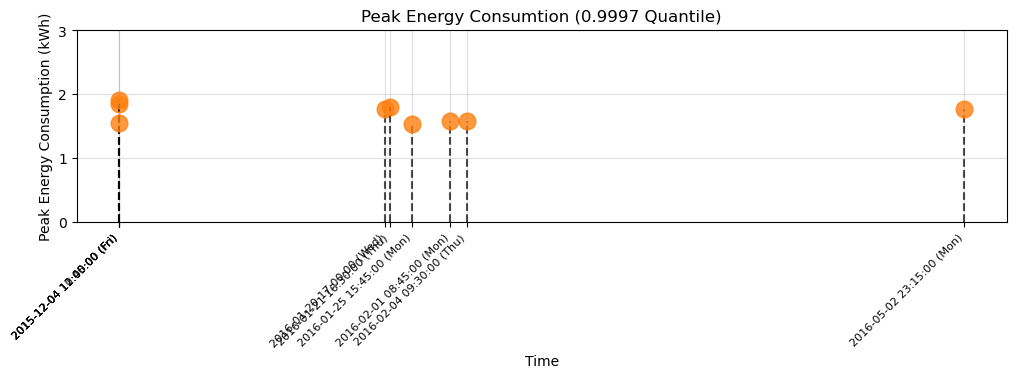

In [24]:
# Creating a plot with vertical bars at the X values and a constant Y value
from time import localtime, strftime

from matplotlib.ticker import MaxNLocator


marked = True
cont_marks = True
max_arrivals = 30
idx = 0

fig, ax = plt.subplots(figsize=(12, 2.5))

# Constant Y value
y_value_const = 1
seq = raw_dataset['sequences'][idx]
x_values = seq['arrival_times'].tolist()[:max_arrivals]
x_ticks = [strftime('%Y-%m-%d %H:%M:%S (%a)', localtime(tt)) for tt in x_values]
if marked:
    if cont_marks:
        y_values = seq['energykWh'].tolist()[:max_arrivals]
    else:
        y_values = seq['marks'].tolist()[:max_arrivals]
else:
    y_values = [y_value_const] * len(x_values)
# Plotting vertical lines for each X value
for x, y in zip(x_values, y_values):
    plt.plot([x, x], [0, y if marked else y_value_const], '--k', alpha=0.7)  # Vertical line (bar)
    plt.plot(x, (y if marked else y_value_const), 'o', alpha=0.8, color='tab:orange', ms=12)  # Circle on top of the bar

plt.title(f'Peak Energy Consumtion {"over" + peak_energy_consumption_type.capitalize()+"s" if peak_energy_consumption_type in PEAK_ENERGY_CONSUMPTION_OVER_TIME[:4] else "("+peak_energy_consumption_type+" Quantile)"}')
plt.xlabel('Time')
ax.set_xticks(x_values)
ax.set_xticklabels(x_ticks)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.ylabel(f'{"Peak Energy Consumption (kWh)" if cont_marks else "Peak Energy Consumption (Level)" if marked else ""}')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, alpha=0.4)
plt.ylim((0., ax.get_ylim()[1]+1))
path = f'../plots/{peak_energy_consumption_type}'
os.makedirs(path, exist_ok=True) 
plt.savefig(f'{path}/peak_energy_consumption_over_{peak_energy_consumption_type}s.png', bbox_inches='tight', dpi=600)
plt.show()


In [8]:
# nb = next(iter(dl_train))
# nb.inter_times
# nb.mask
# nb.marks[1]

In [25]:
# Define the model
print('Building model...')

def build_model():
    mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

    model = dpp.models.LogNormMix(
        num_marks=d_train.num_marks,
        mean_log_inter_time=mean_log_inter_time,
        std_log_inter_time=std_log_inter_time,
        context_size=context_size,
        mark_embedding_size=mark_embedding_size,
        rnn_type=rnn_type,
        num_mix_components=num_mix_components,
    )
    opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)
    
    return model, opt

Building model...


In [26]:
def aggregate_loss_over_dataloader(dl):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_loss += -model.log_prob(batch).sum().item()
            total_count += batch.size
    return total_loss / total_count

In [27]:
# Traning
RUNS = 1
EVALUATE_TRAIN_TEST = True
print('Starting training...')
training_losses_runs = {}
training_losses_runs["valid"] = []
if EVALUATE_TRAIN_TEST:
    training_losses_runs["train"] = []
    training_losses_runs["test"] = []

for run in range(RUNS):
    model, opt = build_model()
    impatient = 0
    best_loss = np.inf
    best_model = deepcopy(model.state_dict())
    training_val_losses= []
    if EVALUATE_TRAIN_TEST:
        training_train_losses = []
        training_test_losses = []

    for epoch in range(max_epochs):
        model.train()
        for batch in dl_train:
            opt.zero_grad()
            loss = -model.log_prob(batch).mean()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            if EVALUATE_TRAIN_TEST:
                loss_train = aggregate_loss_over_dataloader(dl_train)
                loss_test = aggregate_loss_over_dataloader(dl_test)
                training_train_losses.append(loss_train)
                training_test_losses.append(loss_test)
            loss_val = aggregate_loss_over_dataloader(dl_val)
            training_val_losses.append(loss_val)

        if (best_loss - loss_val) < 1e-4:
            impatient += 1
            if loss_val < best_loss:
                best_loss = loss_val
                best_model = deepcopy(model.state_dict())
        else:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
            impatient = 0

        if impatient >= patience:
            print(f'Breaking due to early stopping at epoch {epoch}')
            break

        if epoch % display_step == 0:
            print(f"Epoch {epoch:4d}: loss_train_last_batch = {loss.item():.1f}, loss_val = {loss_val:.1f}")
            
    training_losses_runs["valid"].append(training_val_losses)
    if EVALUATE_TRAIN_TEST:
        training_losses_runs["train"].append(training_train_losses)
        training_losses_runs["test"].append(training_test_losses)

Starting training...


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


Epoch    0: loss_train_last_batch = 189.5, loss_val = 338.3
Epoch    5: loss_train_last_batch = 356.6, loss_val = 310.5
Epoch   10: loss_train_last_batch = 315.9, loss_val = 296.6
Epoch   15: loss_train_last_batch = 400.3, loss_val = 294.0
Epoch   20: loss_train_last_batch = 280.5, loss_val = 291.5
Epoch   25: loss_train_last_batch = 303.4, loss_val = 289.0
Epoch   30: loss_train_last_batch = 206.2, loss_val = 290.8
Epoch   35: loss_train_last_batch = 349.8, loss_val = 295.1
Epoch   40: loss_train_last_batch = 427.9, loss_val = 285.3
Epoch   45: loss_train_last_batch = 238.8, loss_val = 290.0
Epoch   50: loss_train_last_batch = 261.8, loss_val = 287.4
Epoch   55: loss_train_last_batch = 351.5, loss_val = 284.4
Epoch   60: loss_train_last_batch = 286.0, loss_val = 285.0
Epoch   65: loss_train_last_batch = 271.9, loss_val = 288.1
Epoch   70: loss_train_last_batch = 294.1, loss_val = 289.7
Epoch   75: loss_train_last_batch = 288.4, loss_val = 284.1
Epoch   80: loss_train_last_batch = 189.

In [28]:
run_lengths_valid = [len(_t) for _t in training_losses_runs["valid"]]
run_lengths_train = [len(_t) for _t in training_losses_runs["train"]]
min_length = min(min(run_lengths_valid), min(run_lengths_train))

trim_validation_loss_runs_valid = [_t[-min_length:] for _t in training_losses_runs["valid"]]
trim_validation_loss_runs_valid = np.array(trim_validation_loss_runs_valid)
trim_validation_loss_runs_train = [_t[-min_length:] for _t in training_losses_runs["train"]]
trim_validation_loss_runs_train = np.array(trim_validation_loss_runs_train)


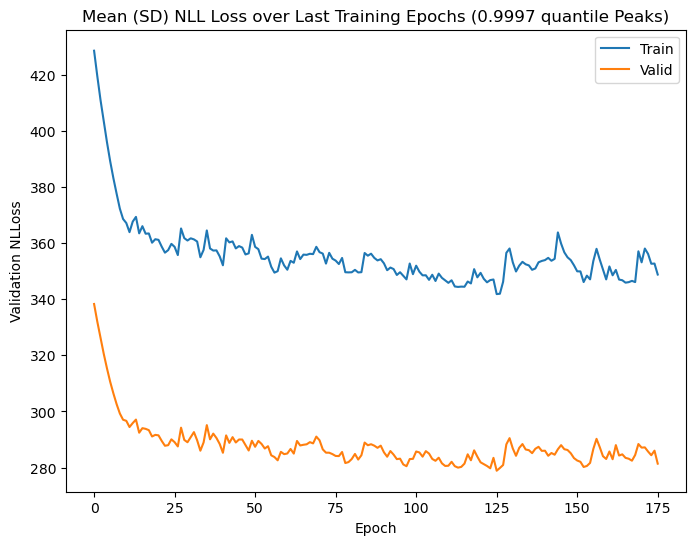

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data creation (replace this with your actual data)
df_vl = pd.DataFrame({
    'x': np.arange(len(trim_validation_loss_runs_valid[0])),
    'mean': np.mean(trim_validation_loss_runs_valid, axis=0),
    'std': np.std(trim_validation_loss_runs_valid, axis=0),
})

df_tr = pd.DataFrame({
    'x': np.arange(len(trim_validation_loss_runs_train[0])),
    'mean': np.mean(trim_validation_loss_runs_train, axis=0),
    'std': np.std(trim_validation_loss_runs_train, axis=0),
})

# Creating the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the mean on the axes
ax.plot(df_tr['x'], df_tr['mean'], color='tab:blue', label='Train')
ax.plot(df_vl['x'], df_vl['mean'], color='tab:orange', label='Valid')

# Adding the ribbon for standard deviation
if RUNS > 1:
    ax.fill_between(df_tr['x'], df_tr['mean'] - df_tr['std'], df_tr['mean'] + df_tr['std'], color='tab:blue', alpha=0.2)
    ax.fill_between(df_vl['x'], df_vl['mean'] - df_vl['std'], df_vl['mean'] + df_vl['std'], color='tab:orange', alpha=0.2)

# Setting titles and labels
ax.set_title(f'Mean (SD) NLL Loss over Last Training Epochs ({PEAK_ENERGY_CONSUMPTION_OVER_TIME_ADV[DS_ID].capitalize()} Peaks)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation NLLoss')

# Adding a legend
ax.legend()

# Display the plot
path = f'../plots/{peak_energy_consumption_type}'
os.makedirs(path, exist_ok=True) 
plt.savefig(f'{path}/nlloss_peak_energy_consumption_over_{peak_energy_consumption_type}s.png', bbox_inches='tight', dpi=600)
plt.show()


In [30]:
# Evaluation
model.load_state_dict(best_model)
model.eval()

# All training & testing sequences stacked into a single batch
with torch.no_grad():
    final_loss_train = aggregate_loss_over_dataloader(dl_train)
    final_loss_val = aggregate_loss_over_dataloader(dl_val)
    final_loss_test = aggregate_loss_over_dataloader(dl_test)

In [31]:
print(f'Negative log-likelihood:\n'
      f' - Train: {final_loss_train:.1f}\n'
      f' - Val:   {final_loss_val:.1f}\n'
      f' - Test:  {final_loss_test:.1f}')

Negative log-likelihood:
 - Train: 341.8
 - Val:   278.9
 - Test:  384.4


Compare the distribution of sequence lengths for real and simulated data

In [32]:
model

LogNormMix(
  (mark_embedding): Embedding(10, 32)
  (mark_linear): Linear(in_features=64, out_features=10, bias=True)
  (rnn): GRU(33, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=192, bias=True)
)

In [33]:
# Unique lengths of sequences in the dataset

span = {}
datasets = [d_train, d_val, d_test]    

for ds, sp in zip(datasets, ["train", "valid", "test"]):
    span[sp] = []
    for i in range(len(ds)):
        span[sp] += [ds[i].t_end - ds[i].t_start,]
    print(sp, len(set(span[sp])))

train 30
valid 14
test 15


In [35]:
sampled_batch = {}

for sp in ["train", "valid", "test",]: 
    sampled_batch[sp]  = []
    for _s in tqdm(span[sp]):
        sampled_batch[sp].append( model.sample(t_end=_s, batch_size=5) )

100%|██████████| 39/39 [00:06<00:00,  6.03it/s]


In [36]:
sample_lengths = {}

for sp in ["train", "valid", "test"]:
    sample_lengths[sp] = np.concatenate([sampled_batch[sp][i].mask.sum(-1).cpu().numpy() for i in range(len(sampled_batch[sp]))])
    print(len(sample_lengths[sp]))

570
190
195


In [20]:
# sampled_batch = model.sample(t_end=72922300, batch_size=1000)
# sampled_batch

In [37]:
real_batch = {}

for sp, ds in zip(["train", "valid", "test"], [d_train, d_val, d_test]):
    real_batch[sp] = dpp.data.Batch.from_list([s for s in ds])

In [38]:
real_batch

{'train': Batch(inter_times=[114, 569], marks=[114, 569], mask=[114, 569]),
 'valid': Batch(inter_times=[38, 43], marks=[38, 43], mask=[38, 43]),
 'test': Batch(inter_times=[39, 239], marks=[39, 239], mask=[39, 239])}

In [39]:
real_lengths = {}

for sp in ["train", "valid", "test"]:
    real_lengths[sp] = real_batch[sp].mask.sum(-1).cpu().numpy()
    print(len(real_lengths[sp]))

114
38
39


In [40]:
real_batch['train']['mask']

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:1')

['monthly', 'weekly', 'daily', 'hourly', '0.9999 Quantile', '0.9998 Quantile', '0.9997 Quantile', '0.9996 Quantile', '0.9995 Quantile', '0.999 Quantile']


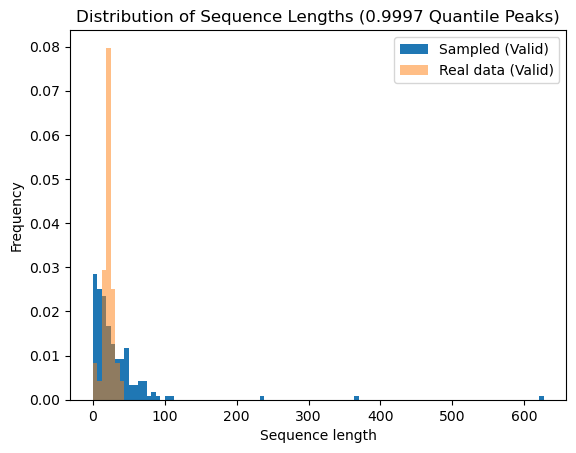

In [52]:
SPLITS = ["train", "valid", "test", "overall"]
split = SPLITS[1]

if split == "overall":
    sample_lengths_to_plot = np.concatenate([sample_lengths[sp] for sp in ["train", "valid", "test"]])
    real_lengths_to_plot = np.concatenate([real_lengths[sp] for sp in ["train", "valid", "test"]])
else:
    sample_lengths_to_plot = sample_lengths[split]
    real_lengths_to_plot = real_lengths[split]

xlim_max = max(max(sample_lengths_to_plot), max(real_lengths_to_plot)) + 1
plt.hist(sample_lengths_to_plot, 100, label=f"Sampled ({split.capitalize()})", density=True, range=(0, xlim_max));
# plt.hist(sampled_batch.mask.sum(-1).cpu().numpy(), 50, label="Sampled", density=True, range=(0, 30));
plt.hist(real_lengths_to_plot, 100, alpha=0.5, label=f"Real data ({split.capitalize()})", density=True, range=(0, xlim_max));
print(PEAK_ENERGY_CONSUMPTION_OVER_TIME_ADV)
plt.title(f'Distribution of Sequence Lengths ({PEAK_ENERGY_CONSUMPTION_OVER_TIME_ADV[DS_ID].title()} Peaks)')
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.legend()

path = f'../plots/{peak_energy_consumption_type}'
os.makedirs(path, exist_ok=True) 
plt.savefig(f'{path}/dist_sequence_length_peak_energy_consumption_over_{peak_energy_consumption_type}s_{split}.png', bbox_inches='tight', dpi=600)

In [54]:
# sample_sequence = sampled_batch['train'][0].inter_times[1]
# torch.cumsum( sample_sequence[sample_sequence != 0], dim=-1 )


In [55]:
# sampled_batch['train'][0].marks[4][sample_sequence != 0]

In [56]:
# torch.cumsum( real_batch['train'].inter_times[0], dim=-1 )

In [57]:
# real_batch['train'].marks[0]

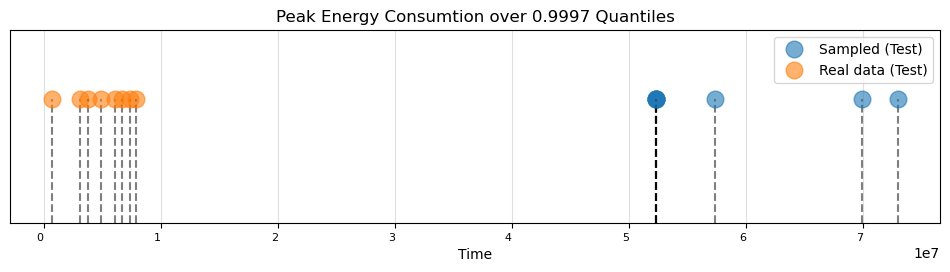

In [63]:
# Creating a plot with vertical bars at the X values and a constant Y value
from time import localtime, strftime

from matplotlib.ticker import MaxNLocator


marked = False
cont_marks = False
max_arrivals = 30
idx = 0

fig, ax = plt.subplots(figsize=(12, 2.5))

# Constant Y value
y_value_const = 1
seq = raw_dataset['sequences'][idx]
sample_sequence = sampled_batch['test'][idx].inter_times[0]

x_values = torch.cumsum( sample_sequence[sample_sequence != 0], dim=-1 ).tolist()[:max_arrivals]
x_values_truth = torch.cumsum( real_batch['test'].inter_times[idx], dim=-1 ).tolist()[:max_arrivals]
# x_ticks = [strftime('%Y-%m-%d %H:%M:%S (%a)', localtime(tt)) for tt in x_values]
if marked:
    if cont_marks:
        y_values = seq['energykWh'].tolist()[:max_arrivals]
    else:
        y_values = seq['marks'].tolist()[:max_arrivals]
else:
    y_values = [y_value_const] * len(x_values)
# Plotting vertical lines for each X value

plot_label=True
for x, y in zip(x_values_truth, y_values):
    plt.plot([x, x], [0, y if marked else y_value_const], '--k', alpha=0.5)  # Vertical line (bar)
    plt.plot(x, (y if marked else y_value_const), 'o', alpha=0.6, color='tab:orange', ms=12, label="Real data (Test)" if plot_label else "")  # Circle on top of the bar
    plot_label=False
    
plot_label=True
for x, y in zip(x_values, y_values):
    plt.plot([x, x], [0, y if marked else y_value_const], '--k', alpha=0.5)  # Vertical line (bar)
    plt.plot(x, (y if marked else y_value_const), 'o', alpha=0.6, color='tab:blue', ms=12, label="Sampled (Test)" if plot_label else "")  # Circle on top of the bar
    plot_label=False

plt.title(f'Peak Energy Consumtion over {PEAK_ENERGY_CONSUMPTION_OVER_TIME_ADV[DS_ID].title()}s')
plt.xlabel('Time')
# ax.set_xticks(x_values)
# ax.set_xticklabels(x_ticks)
plt.xticks(fontsize=8, ha='right')
plt.ylabel(f'{"Peak Energy Consumption (kWh)" if cont_marks else "Peak Energy Consumption (Level)" if marked else ""}')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, alpha=0.4)
plt.ylim((0., ax.get_ylim()[1]+0.5))
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
# plt.legend()
plt.yticks([])
path = f'../plots/{peak_energy_consumption_type}'
os.makedirs(path, exist_ok=True) 
plt.savefig(f'{path}/sampled_sequence_peak_energy_consumption_over_{peak_energy_consumption_type}s_{split}.png', bbox_inches='tight', dpi=600)
plt.show()